In [18]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
import numpy as np
import datetime
import pandas_datareader as web
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

In [19]:
#Date range
start = datetime.datetime(2010, 1, 1)
end = datetime.date(2022, 1, 1)

In [20]:
#Getting the data
petr4 = web.get_data_yahoo('PETR4.SA', start, end)

In [21]:
petr4.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,37.32,36.82,36.95,37.32,13303600.00,23.64
2010-01-05,37.43,36.80,37.38,37.00,21396400.00,23.44
2010-01-06,37.50,36.80,36.80,37.50,18720600.00,23.76
2010-01-07,37.45,37.07,37.27,37.15,10964600.00,23.54
2010-01-08,37.39,36.86,37.16,36.95,14624200.00,23.41


In [22]:
petr4.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-23,28.42,28.15,28.33,28.33,28713600.00,28.33
2021-12-27,28.78,28.15,28.32,28.75,44227900.00,28.75
2021-12-28,29.28,28.70,29.01,28.78,30688100.00,28.78
2021-12-29,28.90,28.42,28.70,28.54,35508400.00,28.54
2021-12-30,28.70,28.39,28.55,28.45,43229100.00,28.45


In [23]:
#shape
petr4.shape

(2975, 6)

In [24]:
#Plot function
def plot_stock(df, stock_name):
    plt.rcParams["figure.figsize"] = [14,5]
    plt.plot(df.index, df['Close'])
    plt.xlabel('Date')
    plt.ylabel('Value R$')
    plt.title(stock_name)

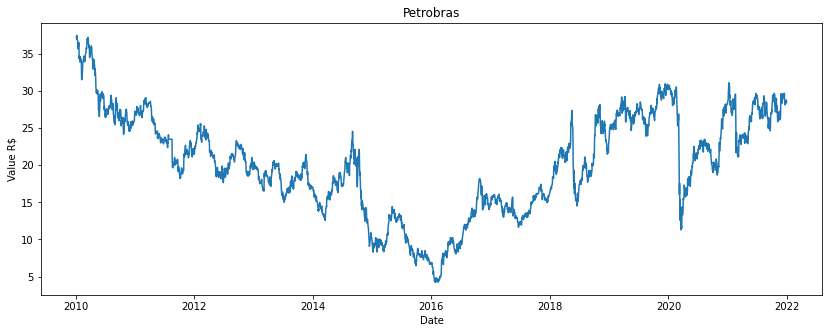

In [25]:
#Plotting PETR4
plot_stock(petr4, 'Petrobras')

In [32]:
#Using only the close value for prediction
petr4 = petr4['Open'].values
petr4 = petr4.reshape(-1, 1)

In [34]:
#Splitting the data
petr4_train = np.array(petr4[:int(petr4.shape[0] * 0.8)])
petr4_test = np.array(petr4[int(petr4.shape[0] * 0.8):])

In [40]:
#Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
petr4_train = scaler.fit_transform(petr4_train)
petr4_test = scaler.fit_transform(petr4_test)

In [48]:
#Function to create the dataset
#The last 50 closing prices define the 51th day price
def create_dataset(df):
    x = []
    y = []
    
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])

    x = np.array(x)
    y = np.array(y)
    
    return x,y

In [49]:
#Creating the dataset for test and training data
x_train, y_train = create_dataset(petr4_train)
x_test, y_test = create_dataset(petr4_test)

In [50]:
#Reshaping the data to 3D model for LSTM layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [54]:
#Building the model
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [55]:
#Reshaping for the LSTM layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [56]:
#Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [57]:
#Training the model
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('petr4_stock_prediction.h5')

Epoch 1/50
73/73 [==============================] - 15s 105ms/step - loss: 0.0129
Epoch 2/50
73/73 [==============================] - 8s 108ms/step - loss: 0.0033
Epoch 3/50
73/73 [==============================] - 9s 122ms/step - loss: 0.0032
Epoch 4/50
73/73 [==============================] - 8s 114ms/step - loss: 0.0029
Epoch 5/50
73/73 [==============================] - 8s 111ms/step - loss: 0.0026
Epoch 6/50
73/73 [==============================] - 8s 105ms/step - loss: 0.0025
Epoch 7/50
73/73 [==============================] - 8s 114ms/step - loss: 0.0025
Epoch 8/50
73/73 [==============================] - 9s 117ms/step - loss: 0.0025
Epoch 9/50
73/73 [==============================] - 9s 122ms/step - loss: 0.0021
Epoch 10/50
73/73 [==============================] - 9s 119ms/step - loss: 0.0020
Epoch 11/50
73/73 [==============================] - 8s 106ms/step - loss: 0.0020
Epoch 12/50
73/73 [==============================] - 8s 106ms/step - loss: 0.0018
Epoch 13/50
73/73 [=====

In [59]:
#Loading the generated model
model = load_model('petr4_stock_prediction.h5')

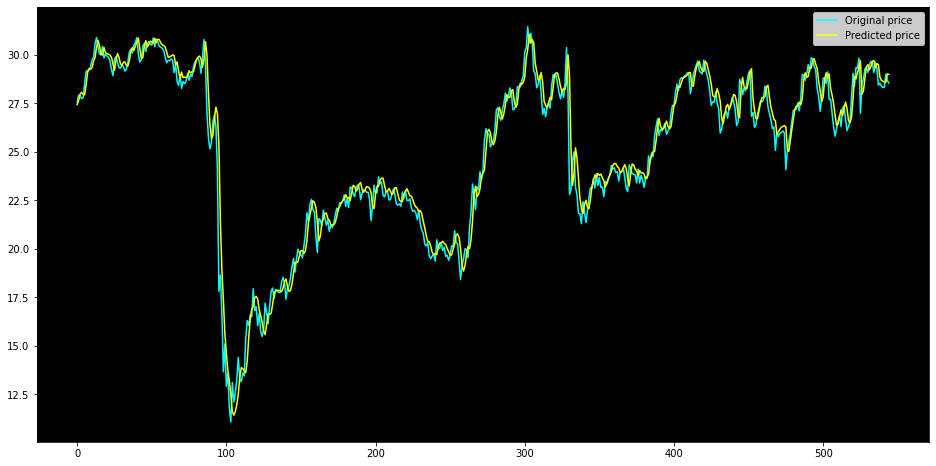

In [65]:
#Making the predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000000')
ax.plot(y_test_scaled, color='cyan', label='Original price')
plt.plot(predictions, color='yellow', label='Predicted price')
plt.legend()